# Text mining project

In [1]:
import nltk
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument # doc2vec
import pandas as pd
import numpy as np
import pickle

In [6]:
# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# results
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from utils import c_matrix
from process_text import processing # preprocessing functions

In [4]:
#setting working directory
#os.chdir("C:/Users/fede9/Documents/GitHub/textmining/code")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocess text

In [4]:
if 'processed_data.csv' not in os.listdir('../data'):
    # load dataset
    df = pd.read_csv("../data/labeled_data.csv", sep = ",").drop("Unnamed: 0", axis=1)
    # apply process_text
    df[["tweet_clean", "rt"]] = df["tweet"].apply(lambda x : processing(x))
    df.to_csv('../data/processed_data.csv', index = False)
else:
    df = pd.read_csv("../data/processed_data.csv", sep = ",")
print("Load & preprocessing --- DONE")

Load & preprocessing --- DONE


In [5]:
# drop tweet list na !!!
df["tweet_list"] = df["tweet_clean"].str.split(" ").tolist()
df.dropna(inplace = True)
df = df.reset_index(drop = True)# drop 2 NA because tweet is empty

## Doc2vec

In [10]:
### doc2vec
# generate model of vectorization
if 'd2v.model' not in os.listdir('../models'):
    documents = [TaggedDocument (doc, [i]) for i, doc in enumerate(df["tweet_list"])]
    model = Doc2Vec (documents, vector_size=100, window=10, min_count=1)
    model.save("../models/d2v.model")
else:
    model = Doc2Vec.load("../models/d2v.model")
print("Doc2Vec model --- DONE")

Doc2Vec model --- DONE


## Vectorization (for doc2vec)

In [11]:
### vectorization
# vettori per tutti i documenti
df["vectors"] = df["tweet_list"].apply(lambda x: model.infer_vector(x))
print("Vectorization --- DONE")

Vectorization --- DONE


## TF-IDF

In [21]:
vectorizer = TfidfVectorizer(
    use_idf=True,
    max_features=10000,
    min_df=5,
    max_df=0.501
    # , ngram_range=(1, 3) Il miglire rimane uni-gram, pessimo score del bi-gram
    )

In [22]:
tfidf = vectorizer.fit_transform(df["tweet_clean"]).toarray()

In [23]:
tfidf.shape

(24781, 3598)

## Vader Sentiment

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
sentiments = []
sentiment_analyzer = VS()
for tweet in df['tweet_clean']:
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    sentiments.append(sentiment)

In [13]:
print(len(sentiments))
print(sentiments[:5])

24781
[{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.2755}, {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.5423}, {'neg': 0.841, 'neu': 0.159, 'pos': 0.0, 'compound': -0.9423}, {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}, {'neg': 0.457, 'neu': 0.37, 'pos': 0.173, 'compound': -0.6808}]


In [14]:
df['tweet_clean'][3]

'look like tranny'

In [23]:
a = "save the motherfucker"

In [24]:
sentiment_analyzer.polarity_scores(a)

{'neg': 0.523, 'neu': 0.114, 'pos': 0.364, 'compound': -0.34}

In [12]:
neg = []
neu = []
pos = []
compound = []
for sentiment in sentiments:
    neg.append(sentiment['neg'])
    neu.append(sentiment['neu'])
    pos.append(sentiment['pos'])
    compound.append(sentiment['compound']) 

# save in dataframe  
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos
df['compound'] = compound

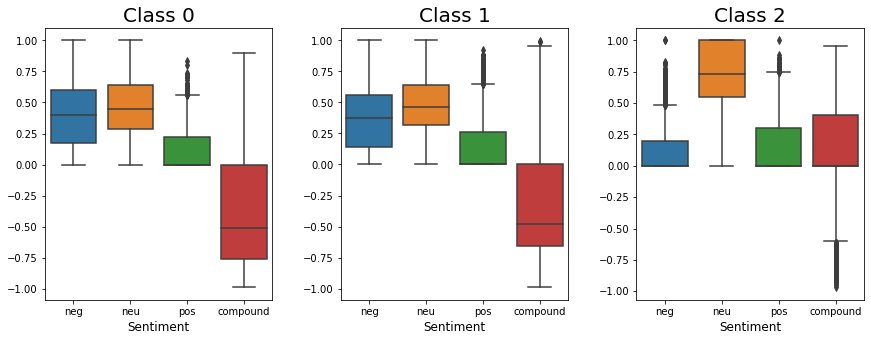

In [58]:
selected_columns = ["neg", "neu", "pos", "compound"]

fig, axs = plt.subplots(ncols = 3, figsize=(13,5))
for i in range(3):
    sns.boxplot(x="variable", y="value", data=pd.melt(df[df['class'] == i][selected_columns]), ax = axs[i])
    axs[i].set_title(f"Class {i}", size = 20)
    axs[i].set_xlabel("Sentiment", size = 12)
    axs[i].set_ylabel("")
    #axs[i].set_xticks(size = 12)
    #axs[i].set_yticks(size = 12)
plt.subplots_adjust(right = 1, wspace = 0.3)

In [17]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_clean,tweet_list,neg,neu,pos,compound
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...,"[woman, shouldnt, complain, cleaning, house, m...",0.000,0.791,0.209,0.2755
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",0.259,0.741,0.000,-0.5423
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confuse shit,"[dawg, ever, fuck, bitch, start, cry, confuse,...",0.841,0.159,0.000,-0.9423
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny,"[look, like, tranny]",0.000,0.444,0.556,0.3612
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch tell ya,"[shit, hear, might, true, might, faker, bitch,...",0.457,0.370,0.173,-0.6808


## Text classification

In [24]:
# prepare data
#X_data = np.stack(df["vectors"], axis = 0)
#X_data = pd.concat([pd.DataFrame(tfidf), df[['neg', 'neu', 'pos', 'compound']]], axis = 1)
X_data = pd.concat([pd.DataFrame(tfidf), df["rt"]], axis = 1)
Y_data = df["class"]

# verifica dimensioni vettori
assert X_data.shape[0] == Y_data.shape[0]

In [25]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                   test_size = 0.2,
                                                   random_state = 42,
                                                   shuffle = True,
                                                   stratify = Y_data)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [26]:
# class weights
# w_J = n_samples / (n_classes * n_samples_J)
weights = len(df['class']) / (3 * df['class'].value_counts())
# model
model = SVC(random_state = 42, 
            class_weight= {0 : weights[0], 1 : weights[1], 2 : weights[2]})

In [27]:
%%time
# fitting
model.fit(X_train, y_train)
print("Modelling --- DONE")

Modelling --- DONE
Wall time: 24min 31s


In [30]:
# save model
filename = 'svm_retweet.sav'
pickle.dump(model, open(f'../models/{filename}', 'wb'))

In [18]:
# load model
filename = 'svm_sentiment.sav'
model_2 = pickle.load(open(f'../models/{filename}', 'rb'))

## Comments

Modelli e risultati di accuracy sul test
- 10000 tfidf best model yet 92% (**non mi ricordo spero sia corretta**)
- 10000 tfidf, 4 sentiment riduce un pochino la performance 83% (**non ricordo quanto fosse**)
- 100 tfidf, retweet **83%**
- 10000 tfidf, retweet *24 min* **89%**

## Performance

### Train

Classification report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.83      1144
           1       1.00      0.94      0.97     15351
           2       0.86      0.99      0.92      3329

    accuracy                           0.95     19824
   macro avg       0.86      0.98      0.91     19824
weighted avg       0.96      0.95      0.95     19824



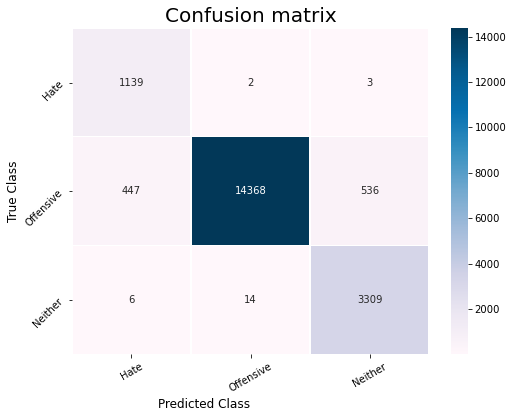

Wall time: 14min 24s


In [28]:
%%time
# performance on TRAIN
y_pred = model.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Hate", "Offensive", "Neither"])

### Test

Classification report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       286
           1       0.96      0.91      0.93      3838
           2       0.79      0.95      0.86       833

    accuracy                           0.89      4957
   macro avg       0.72      0.77      0.74      4957
weighted avg       0.90      0.89      0.89      4957



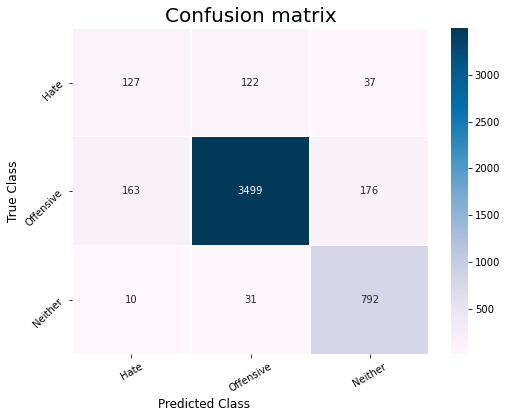

Wall time: 3min 33s


In [29]:
%%time
# performance on TEST
y_pred = model.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Hate", "Offensive", "Neither"]) 